# 6. ANALYSING TRACES

* 어바웃 파이썬 : 11월 - PsychoPy [1]
* 김무성

# Contents
* Introduction 
    - Pupil Size
    - PyGaze Analyser
* Read eye-tracker data
* Plot your first trace
* Averaging traces

#### 준비단계 
* ../ 폴더의 setup.ipynb 실행한 후

In [3]:
# 현재 디렉토리 확인 
%ls

07_ANALYSING_TRACES.ipynb


In [4]:
# 실습 관련 책의 코드와 데이터
%ls ..

PEP_all-in-one/       all-in-one.zip        ch07/
README.md             ch03/                 hello_psychopy.ipynb
Untitled.ipynb        ch04/                 new.txt
Untitled1.ipynb       ch05/                 result.txt
all-in-one (1).zip    ch06/                 setup.ipynb


In [10]:
%ls ../PEP_all-in-one/Chapter_07/* 

../PEP_all-in-one/Chapter_07/code:
Analysing_traces.zip

../PEP_all-in-one/Chapter_07/data:
ED_pupil.asc

../PEP_all-in-one/Chapter_07/files:
Analysing_traces_output.png


In [11]:
# 실습 파일 가져오자
%cp -r ../PEP_all-in-one/Chapter_07 .

In [13]:
%ls * 

07_ANALYSING_TRACES.ipynb

Chapter_07:
code/  data/  files/


# Scripts

In [1]:
# 작업 디렉토리 이동 
%cd Chapter_07/code/

/Users/moodern/work/00_aboutpython_psychopy/ch07/Chapter_07/code


In [15]:
%ls

Analysing_traces.zip


In [16]:
# 압축파일을 풀기위한 패키지
import zipfile

In [17]:
all_zip = zipfile.ZipFile('Analysing_traces.zip')
all_zip.extractall('./')
all_zip.close()

In [18]:
%ls 

Analysing_traces/     Analysing_traces.zip


In [2]:
# 작업 디렉토리 이동
%cd Analysing_traces/

/Users/moodern/work/00_aboutpython_psychopy/ch07/Chapter_07/code/Analysing_traces


In [ ]:
%ls

In [26]:
%cp ../../data/ED_pupil.asc .

In [27]:
%ls

ED_pupil.asc    analysis.py     pygazeanalyser/


### 실행 방법 1. 
콘솔창을 열어서 
python analysis.py 

### 실행 방법 2.

In [28]:
# 노트북에서 직접 실행
!python analysis.py

Traceback (most recent call last):
  File "analysis.py", line 32, in <module>
    baseline = data[i]['size'][t1i:t2i]
TypeError: only integer scalar arrays can be converted to a scalar index


### 실행 방법 3.

In [4]:
import numpy
from matplotlib import pyplot
from scipy.stats import ttest_rel
from pygazeanalyser.edfreader import read_edf

# read data file
data = read_edf('ED_pupil.asc', 'PUPIL_TRIALSTART', \
    stop='pupdata_stop')

In [16]:
i = 0

t0, msg = data[i]['events']['msg'][0]
if 'black' in msg:
    trialtype = 'black'
elif 'white' in msg:
    trialtype = 'white'
    
# get the timestamps of baseline and monitor change
t1, msg = data[i]['events']['msg'][1]
t2, msg = data[i]['events']['msg'][2]
# turn the timestamps into index numbers
t1i = numpy.where(data[i]['trackertime'] == t1)[0]
t2i = numpy.where(data[i]['trackertime'] == t2)[0]

In [17]:
t1i

array([0])

In [11]:
import numpy
from matplotlib import pyplot
from scipy.stats import ttest_rel
from pygazeanalyser.edfreader import read_edf

# read data file
data = read_edf('ED_pupil.asc', 'PUPIL_TRIALSTART', \
    stop='pupdata_stop')


# create a new dict to contain traces
traces = {'black':[], 'white':[]}

# loop through all trials
n_trials = len(data)

for i in range(n_trials):
    
    # check the trial type
    t0, msg = data[i]['events']['msg'][0]
    if 'black' in msg:
        trialtype = 'black'
    elif 'white' in msg:
        trialtype = 'white'
    
    # get the timestamps of baseline and monitor change
    t1, msg = data[i]['events']['msg'][1]
    t2, msg = data[i]['events']['msg'][2]
    # turn the timestamps into index numbers
    t1i = numpy.where(data[i]['trackertime'] == t1)[0][0] # <- here
    t2i = numpy.where(data[i]['trackertime'] == t2)[0][0] # <- here
    
    
    
    # get the baseline trace
    baseline = data[i]['size'][t1i:t2i]
    # get the pupil change trace (2000 samples)
    trace = data[i]['size'][t2i:t2i+2000]
    
    # divide the pupil trace by the baseline median
    trace = trace / numpy.median(baseline)
    
    # add the trace to the list for this trial type
    traces[trialtype].append(trace)
    
# convert lists to NumPy arrays
traces['black'] = numpy.array(traces['black'])
traces['white'] = numpy.array(traces['white'])

# create an empty dict to contain mean and SEM
avgs = {'black':{}, 'white':{}}
# loop through both conditions
for con in ['black', 'white']:
    # calculate the number of trials in this condition
    n_trials = len(traces[con])
    # calculate the average trace in this condition
    avgs[con]['M'] = numpy.mean(traces[con], axis=0)
    # calculate the standard deviation in this condition
    sd = numpy.std(traces[con], axis=0)
    # calculate the standard error in this condition
    avgs[con]['SEM'] = sd / numpy.sqrt(n_trials)

# do a t-test on every timepoint
t, p = ttest_rel(traces['black'], traces['white'], axis=0)

# Bonferroni-corrected alpha
alpha = 0.05 / len(t)

# define the plotting colours
cols = {'black':'#204a87', 'white':'#c4a000'}
# create a new figure with a single axis
fig, ax = pyplot.subplots(figsize=(19.2,10.8), dpi=100.0)

# loop through the conditions
for con in ['black', 'white']:
    # create x-values
    x = range(len(avgs[con]['M']))
    # plot the mean trace
    ax.plot(x, avgs[con]['M'], '-', color=cols[con], \
        label=con)
    # plot the standard error of the mean shading
    y1 = avgs[con]['M'] + avgs[con]['SEM']
    y2 = avgs[con]['M'] - avgs[con]['SEM']
    ax.fill_between(x, y1, y2, color=cols[con], alpha=0.3)

# create y arrays
y1 = numpy.zeros(len(x))
y2 = numpy.ones(len(x)) * 2
# shade significant difference between traces
ax.fill_between(x, y1, y2, where=p<alpha, \
    color='#babdb6', alpha=0.2)

# set axes limits
ax.set_xlim([0, 2000])
ax.set_ylim([0, 2])
# set axis labels
ax.set_xlabel('time (ms)')
ax.set_ylabel('proportional pupil size change')
# add legend
ax.legend(loc='upper left')

fig.savefig('pupil_traces.png')

In [12]:
%ls

ED_pupil.asc      analysis.py       pupil_traces.png  pygazeanalyser/


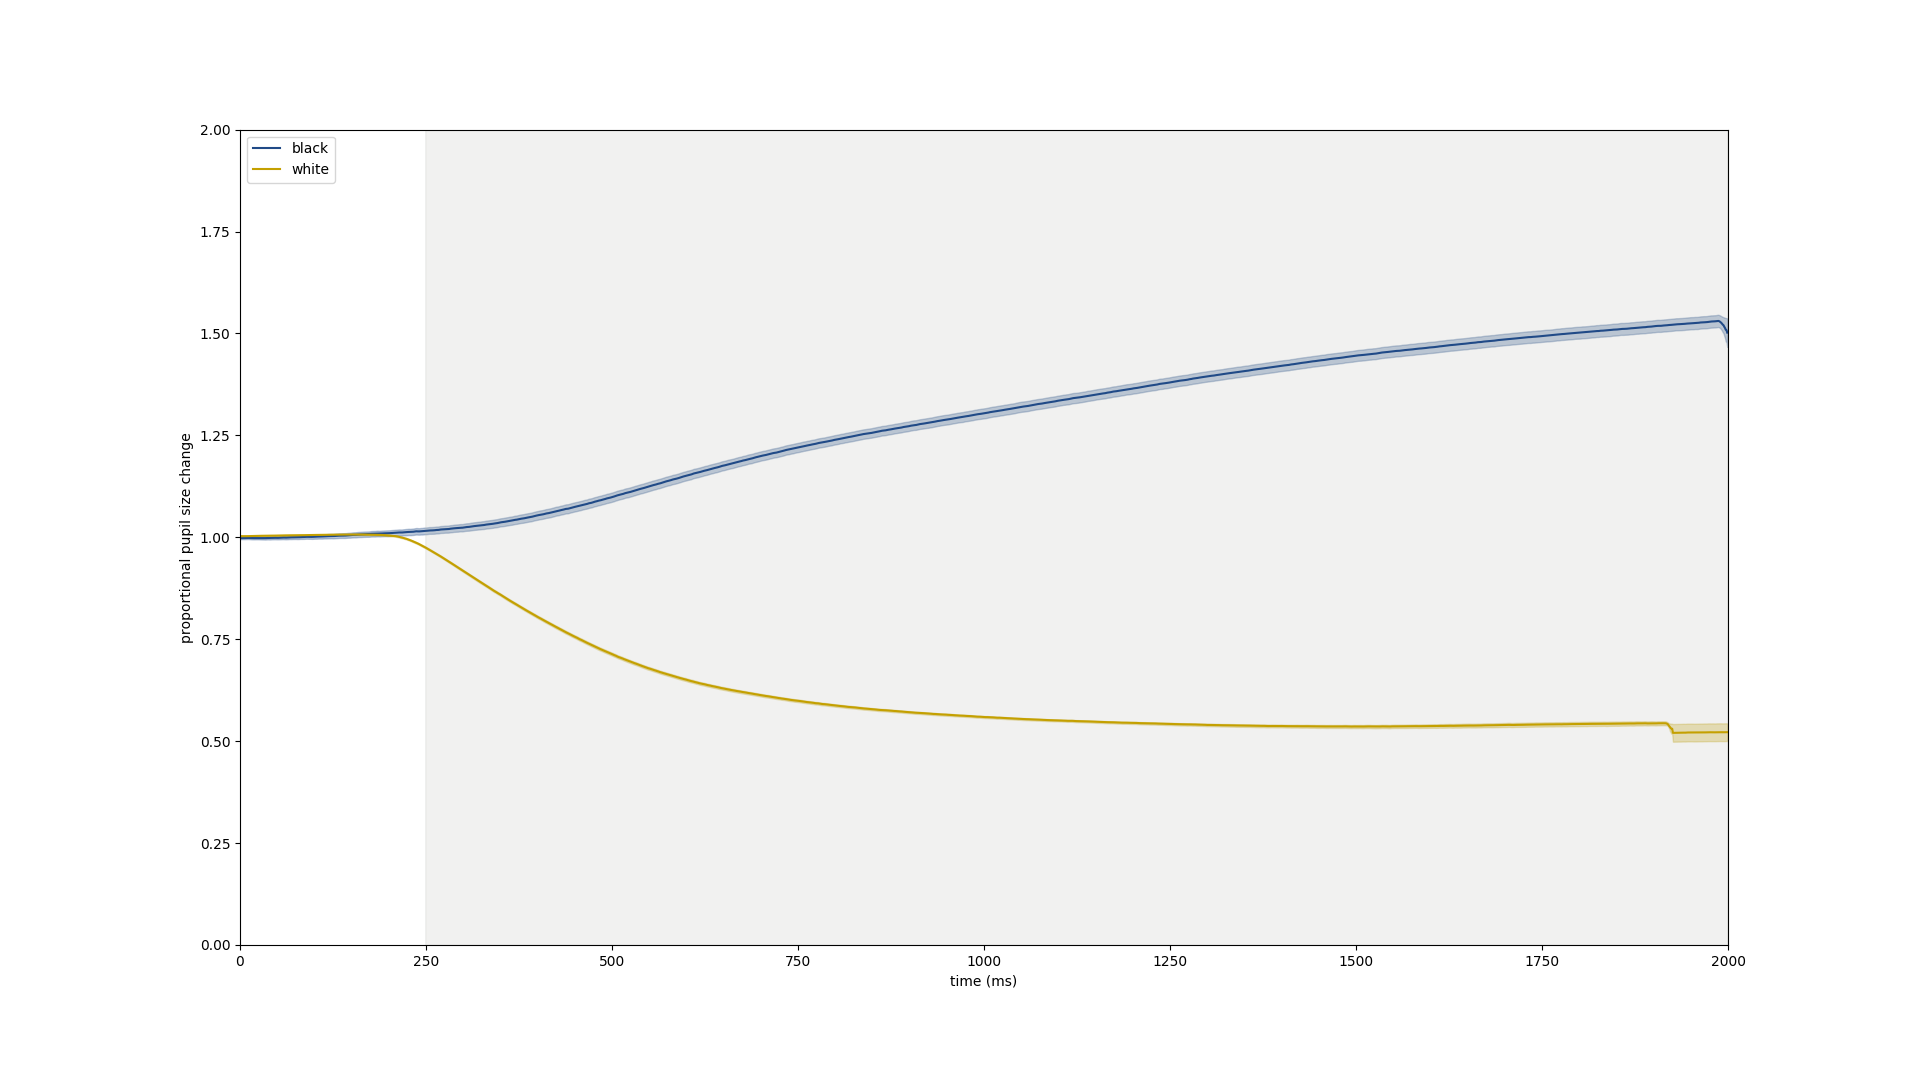

In [14]:
from IPython.display import Image
Image("pupil_traces.png")

# Introduction 
* Pupil Size
* PyGaze Analyser

## Pupil Size

In this section, you will use an example dataset of pupillometry measurements. You can download it from the companion website <http://www.routledge.com/cw/dalmaijer/>. Put this file in a new empty folder.

The data was collected in a very straightforward experimental design: participants looked at a computer monitor that had a grey fixation dot. Every few seconds the display changed from black to white, or vice versa.

The effect of lighting on pupil size is rather strong: The pupil contracts when the eyes are exposed to bright light, and it dilates when there is little light. The pupil is a bit slow to respond, though. Usually, a change in pupil size becomes apparent after about half a second (or a little under).

The data in the example file was collected with an EyeLink 1000 (SR Research Ltd). This is an eye tracker: a fancy camera that can recognise and follow eyes, and can measure the diameter (and surface area) of pupils. The EyeLink 1000 operates at 1000 Hz, which means that it provides one snapshot of the pupil diameter every millisecond.

(이 절에서는 Pupillometry 측정의 예제 데이터 세트를 사용합니다. 컴패니언 웹 사이트 http://www.routledge.com/cw/dalmaijer/ 에서 다운로드 할 수 있습니다. 이 파일을 새 빈 폴더에 넣으십시오.
데이터는 매우 간단한 실험 디자인으로 수집되었습니다. 참가자는 회색 고정 점이있는 컴퓨터 모니터를 보았습니다. 몇 초마다 디스플레이가 검은 색에서 흰색으로 또는 그 반대로 변경되었습니다.

동공 크기에 대한 조명 효과는 다소 강하다 : 눈이 밝은 빛에 노출되면 눈금이 줄어들고 빛이 거의 없을 때 눈꺼풀이 넓어진다. 그러나 학생은 약간 느리게 반응합니다. 보통, 학생의 크기 변화는 약 0.5 초 후 (또는 약간 아래) 명백해진다.

예제 파일의 데이터는 EyeLink 1000 (SR Research Ltd)으로 수집되었습니다. 이것은 눈 추적기입니다. 눈을 인식하고 따라갈 수있는 멋진 카메라이며, 학생의 지름 (및 표면적)을 측정 할 수 있습니다. EyeLink 1000은 1000Hz에서 작동합니다. 즉, 밀리 초마다 동공 지름의 스냅 샷을 제공합니다.)

In [19]:
%ls

ED_pupil.asc      analysis.py       pupil_traces.png  pygazeanalyser/


In [28]:
!head -n 50 ED_pupil.asc 

## PyGaze Analyser

To read the EyeLink’s data file, you can use PyGaze Analyser. You can download the package from http://www.routledge.com/cw/dalmaijer. After downloading the zipped archive, unzip it and copy the folder called ‘pygazeanalyser’ to your new analysis folder (where the example data file is).

PyGaze Analyser is currently a relatively simple library that can extract data from EyeLink, EyeTribe, and SensoMotoric Instruments (SMI) files. In addition, it provides functions for high-level plotting of gaze fixation data, which can produce fancy pictures. You will encounter these in a later section.


# Read eye-tracker data

In [29]:
%matplotlib inline

import numpy
from matplotlib import pyplot
from scipy.stats import ttest_rel
from pygazeanalyser.edfreader import read_edf


In [30]:
# read data file
data = read_edf('ED_pupil.asc', 'PUPIL_TRIALSTART', \
    stop='pupdata_stop')

This reads the file, and stores its contents in a new variable (data). This variable is quite large and quite complex, so an explanation is in order. data is a list that contains values of single trials (one trial per index). In this case there were 50 trials, so len(data)==50. You can refer to a single trial by using data[n], where n is the trial number.

Each single trial is represented by a dict. These dicts always have the same six keys. The first are ‘trackertime’ and ‘time’. Both of these are NumPy arrays that contain the timestamps of all data samples. The timestamps in ‘trackertime’ are in the time that the eye tracker reported. The timestamps in ‘time’ start at 0 in every trial.

The next three keys are ‘x’, ‘y’, and ‘size’. These are all NumPy arrays. ‘x’ contains samples of the horizontal gaze position, and ‘y’ of the vertical gaze position (that is: at which pixel on the monitor a participant was looking). ‘size’ contains samples of the pupil size. These can represent either the pupil surface area, or the pupil diameter (which depends on the EyeLink’s settings during testing). Pupil size was measured in arbitrary units, which are relative to the specific setup and participant. Note that these units do not quite mean anything in the real world, and that you can’t compare them between participants.

(이것은 파일을 읽고 그 내용을 새로운 변수 (데이터)에 저장합니다. 이 변수는 상당히 크고 복잡하기 때문에 설명이 순서대로 이루어집니다. 데이터는 단일 시도 (인덱스 당 하나의 평가판) 값을 포함하는 목록입니다. 이 경우 50 건의 시련이 있었기 때문에 len (data) == 50이됩니다. 데이터 [n]을 사용하여 단일 평가판을 참조 할 수 있습니다. 여기서 n은 평가판 번호입니다.

각각의 단일 재판은 dict로 표시됩니다. 이 dicts에는 항상 동일한 6 개의 열쇠가있다. 첫 번째는 'trackertime'과 'time'입니다. 이 두 가지 모두 모든 데이터 샘플의 타임 스탬프가 포함 된 NumPy 배열입니다. 'trackertime'의 타임 스탬프는 아이 추적기가보고 한 시간입니다. 'time'의 타임 스탬프는 모든 평가판에서 0부터 시작합니다.

다음 세 개의 키는 'x', 'y'및 '크기'입니다. 이것들은 모두 NumPy 배열입니다. 'x'는 수평 시선 위치의 샘플과 수직 시선 위치의 'y'를 포함합니다 (즉, 참가자가 모니터의 어느 픽셀을 보는지). '크기'는 동공 크기의 샘플을 포함합니다. 이들은 동공 표면 영역 또는 동공 지름을 나타낼 수 있습니다 (테스트 중 EyeLink의 설정에 따라 다름). 동공 크기는 특정 설정 및 참가자와 관련된 임의의 단위로 측정되었습니다. 이 단위는 실제 세계에서는 의미가 없으며 참가자간에 비교할 수 없다는 점에 유의하십시오.)

In [32]:
data[0]

{'events': {'Eblk': [],
  'Efix': [[476144, 479160, 3017, 520.8, 379.5]],
  'Esac': [],
  'Sblk': [],
  'Sfix': [],
  'Ssac': [],
  'msg': [[476461, 'PUPIL_TRIALSTART, colour=black\n'],
   [476461, 'baseline_start\n'],
   [476661, 'pupdata_start\n']]},
 'size': array([ 5139.,  5133.,  5132., ...,  8833.,  8834.,  8835.]),
 'time': array([   0,    1,    2, ..., 2698, 2699, 2700]),
 'trackertime': array([476461, 476462, 476463, ..., 479159, 479160, 479161]),
 'x': array([ 527.8,  527.8,  527.7, ...,  518.2,  518.3,  518.5]),
 'y': array([ 362.2,  362.1,  362.1, ...,  396.6,  396.5,  396.5])}

In [34]:
data[0]['events']['msg']

[[476461, 'PUPIL_TRIALSTART, colour=black\n'],
 [476461, 'baseline_start\n'],
 [476661, 'pupdata_start\n']]

As you can see, this is a list of all logged events. Each event is a list itself, containing a timestamp (in trackertime!) and the actual message.


# Plot your first trace

In [35]:
data[0]['size']

array([ 5139.,  5133.,  5132., ...,  8833.,  8834.,  8835.])

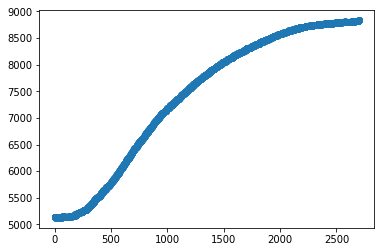

In [36]:
# This plots the pupil size in the first trial, 
# and marks every sample with a circle marker (‘o’).
pyplot.plot(data[0]['size'], 'o')
pyplot.show()

In [37]:
data[0]['events']['msg'][0]

[476461, 'PUPIL_TRIALSTART, colour=black\n']

In [38]:
data[0]['events']['msg'][1]

[476461, 'baseline_start\n']

In [39]:
data[0]['events']['msg'][2]

[476661, 'pupdata_start\n']

In [40]:
t1, msg = data[0]['events']['msg'][1]

In [41]:
t1

476461

In [42]:
msg

'baseline_start\n'

In [63]:
t2, msg = data[0]['events']['msg'][2]

In [43]:
# With NumPy’s where function, 
# you can find the index numbers 
# for which a certain logical statement is True. 
# Type this into the Interpreter:
numpy.where(data[0]['trackertime'] == t1)

(array([0]),)

In [44]:
data[0]['trackertime']

array([476461, 476462, 476463, ..., 479159, 479160, 479161])

In [45]:
data[0]['trackertime'] == t1

array([ True, False, False, ..., False, False, False], dtype=bool)

In [47]:
numpy.where(data[0]['trackertime'] == t1)

(array([0]),)

In [48]:
numpy.where(data[0]['trackertime'] == t1)[0]

array([0])

In [49]:
numpy.where(data[0]['trackertime'] == t1)[0][0]

0

In [ ]:
# The variables t1i and t2i now refer 
# to the index number 
# of sample arrays(‘time’, ‘trackertime’, ‘x’, ‘y’, and ‘size’) 
# that correspond to t1 (baseline start) and t2 (monitor change). 
# You can use these indices to select the baseline, 
# and the pupil response to a monitor change. 
# Type the following in the Interpreter:

In [53]:
t1i = numpy.where(data[0]['trackertime'] == t1)[0]
t1i

array([0])

In [55]:
t2i = numpy.where(data[0]['trackertime'] == t2)[0]

In [56]:
data[0]['size']

array([ 5139.,  5133.,  5132., ...,  8833.,  8834.,  8835.])

In [57]:
baseline = data[0]['size'][t1i:t2i]

TypeError: only integer scalar arrays can be converted to a scalar index

In [58]:
t1i = numpy.where(data[0]['trackertime'] == t1)[0][0]
t2i = numpy.where(data[0]['trackertime'] == t2)[0][0]

In [61]:
print(t1i)
print(t2i)

0
200


In [59]:
baseline = data[0]['size'][t1i:t2i]

In [60]:
baseline

array([ 5139.,  5133.,  5132.,  5131.,  5132.,  5131.,  5131.,  5132.,
        5128.,  5124.,  5124.,  5128.,  5132.,  5132.,  5132.,  5131.,
        5132.,  5133.,  5135.,  5135.,  5133.,  5132.,  5132.,  5133.,
        5134.,  5135.,  5136.,  5137.,  5137.,  5137.,  5133.,  5129.,
        5127.,  5130.,  5132.,  5132.,  5135.,  5139.,  5142.,  5141.,
        5135.,  5129.,  5127.,  5131.,  5132.,  5129.,  5126.,  5131.,
        5134.,  5140.,  5142.,  5145.,  5145.,  5143.,  5134.,  5125.,
        5121.,  5124.,  5127.,  5134.,  5140.,  5143.,  5138.,  5134.,
        5133.,  5131.,  5129.,  5134.,  5140.,  5143.,  5140.,  5139.,
        5140.,  5142.,  5147.,  5152.,  5154.,  5154.,  5153.,  5152.,
        5147.,  5143.,  5142.,  5142.,  5142.,  5146.,  5148.,  5147.,
        5143.,  5141.,  5141.,  5141.,  5137.,  5134.,  5133.,  5136.,
        5140.,  5138.,  5134.,  5134.,  5138.,  5141.,  5138.,  5134.,
        5133.,  5133.,  5134.,  5133.,  5132.,  5133.,  5136.,  5140.,
      

In [62]:
trace = data[0]['size'][t2i:]

However, you don’t have to use an artificial eye. Pupil size is known to fluctuate over time. In fact, it decreases quite dramatically during the course of most (boring) experiments. Therefore, researchers often calculate the proportional change in pupil size. This is the pupil size divided by the average (or median) pupil size during a baseline period. It reflects the relative increase or decrease in pupil size. You can calculate this by typing the following line in the Interpreter, and hitting Enter.
(그러나 인공 눈을 사용할 필요는 없습니다. 동공 크기는 시간이 지남에 따라 변동하는 것으로 알려져 있습니다. 사실, 그것은 대부분의 (지루한) 실험 과정에서 상당히 극적으로 감소합니다. 따라서 연구자들은 종종 동공 크기의 비례 변화를 계산합니다. 이것은 기준선 기간 동안 동공 크기를 평균 (또는 중앙값) 학생 크기로 나눈 값입니다. 이는 학생의 상대적 크기의 증가 또는 감소를 반영합니다. 인터프리터에서 다음 줄을 입력하고 Enter 키를 눌러 계산할 수 있습니다.)

In [64]:
prop_trace = trace / numpy.median(baseline)

In [65]:
prop_trace

array([ 1.01108518,  1.01186309,  1.01283547, ...,  1.71781408,
        1.71800856,  1.71820303])

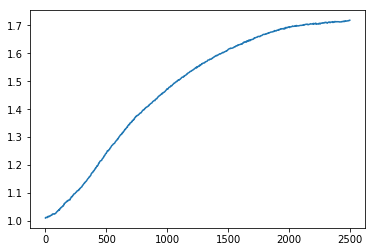

In [66]:
pyplot.plot(prop_trace, '-')
pyplot.show()

# Averaging traces

The next step is to loop through all traces, and collect all pupil responses to changes in monitor luminance. These changes would be light-to-dark in black screen trials, and dark-to-light in white screen trials. Open your analysis.py from the previous chapter in an Editor. Add the following lines:
(다음 단계는 모든 추적을 반복하고 모니터 밝기의 변화에 대한 모든 동공 응답을 수집하는 것입니다. 이러한 변화는 검은 화면 시합에서 어둡거나 흰색 화면 시연에서 어둡거나 어두울 것입니다)

In [70]:
# create a new dict to contain traces
traces = {'black':[], 'white':[]}

# loop through all trials
n_trials = len(data)

for i in range(n_trials):
    
    # check the trial type
    t0, msg = data[i]['events']['msg'][0]
    if 'black' in msg:
        trialtype = 'black'
    elif 'white' in msg:
        trialtype = 'white'
    
    # get the timestamps of baseline and monitor change
    t1, msg = data[i]['events']['msg'][1]
    t2, msg = data[i]['events']['msg'][2]
    # turn the timestamps into index numbers
    t1i = numpy.where(data[i]['trackertime'] == t1)[0][0] # <- here
    t2i = numpy.where(data[i]['trackertime'] == t2)[0][0] # <- here
    
    
    
    # get the baseline trace
    baseline = data[i]['size'][t1i:t2i]
    # get the pupil change trace (2000 samples)
    trace = data[i]['size'][t2i:t2i+2000]
    
    # divide the pupil trace by the baseline median
    trace = trace / numpy.median(baseline)
    
    # add the trace to the list for this trial type
    traces[trialtype].append(trace)


In [71]:
# convert lists to NumPy arrays
traces['black'] = numpy.array(traces['black'])
traces['white'] = numpy.array(traces['white'])

# create an empty dict to contain mean and SEM
avgs = {'black':{}, 'white':{}}
# loop through both conditions
for con in ['black', 'white']:
    # calculate the number of trials in this condition
    n_trials = len(traces[con])
    # calculate the average trace in this condition
    avgs[con]['M'] = numpy.mean(traces[con], axis=0)
    # calculate the standard deviation in this condition
    sd = numpy.std(traces[con], axis=0)
    # calculate the standard error in this condition
    avgs[con]['SEM'] = sd / numpy.sqrt(n_trials)

In [72]:
# do a t-test on every timepoint
t, p = ttest_rel(traces['black'], traces['white'], axis=0)

In [73]:
# Bonferroni-corrected alpha
alpha = 0.05 / len(t)

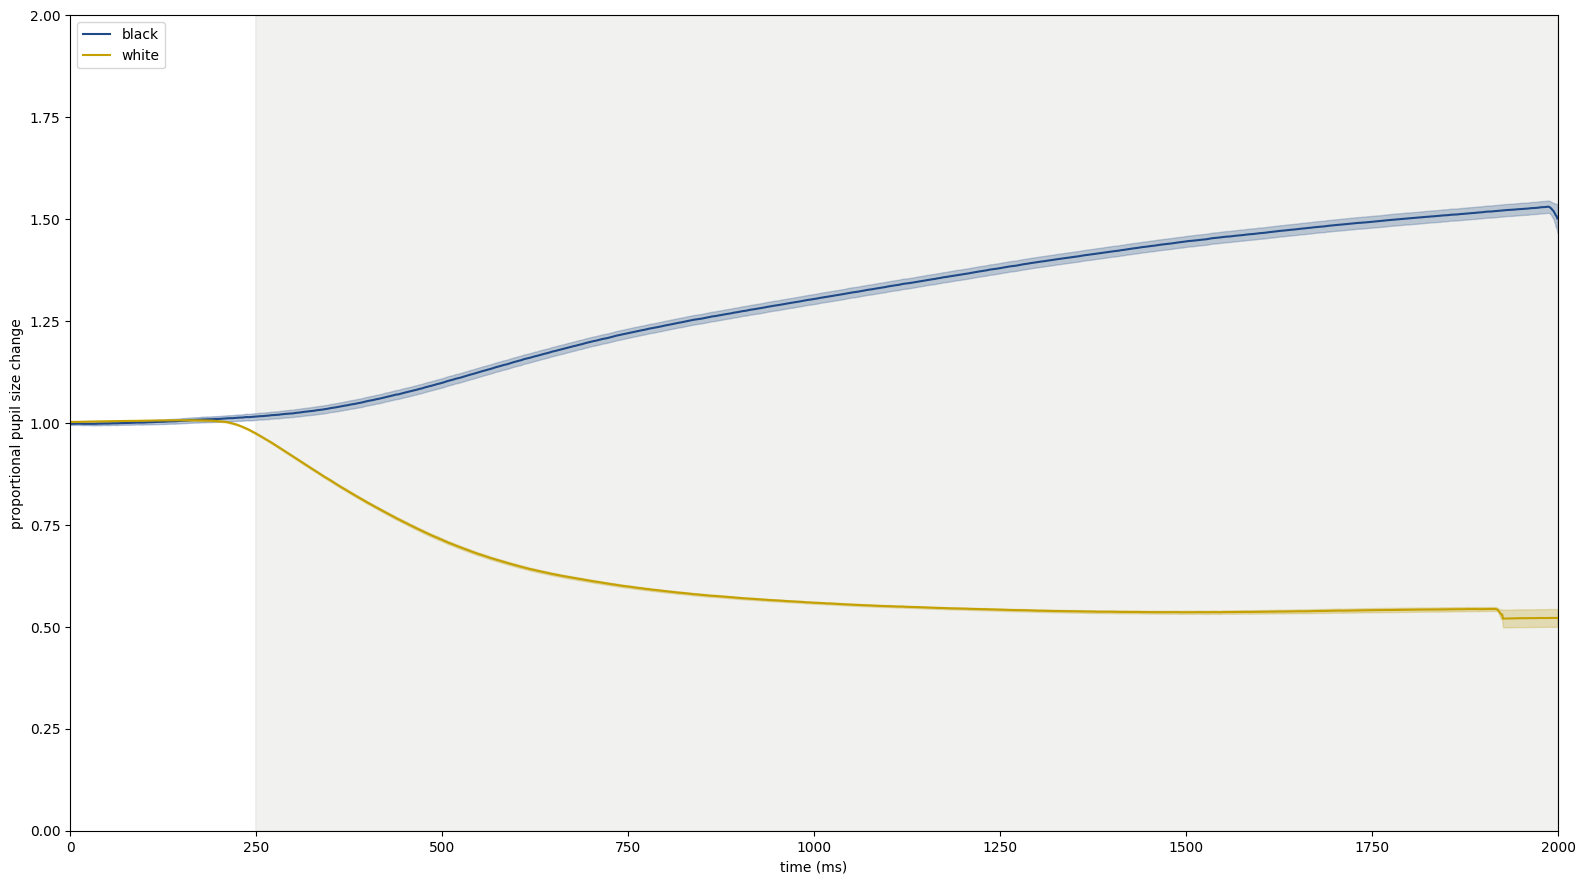

In [74]:
# define the plotting colours
cols = {'black':'#204a87', 'white':'#c4a000'}
# create a new figure with a single axis
fig, ax = pyplot.subplots(figsize=(19.2,10.8), dpi=100.0)

# loop through the conditions
for con in ['black', 'white']:
    # create x-values
    x = range(len(avgs[con]['M']))
    # plot the mean trace
    ax.plot(x, avgs[con]['M'], '-', color=cols[con], \
        label=con)
    # plot the standard error of the mean shading
    y1 = avgs[con]['M'] + avgs[con]['SEM']
    y2 = avgs[con]['M'] - avgs[con]['SEM']
    ax.fill_between(x, y1, y2, color=cols[con], alpha=0.3)

# create y arrays
y1 = numpy.zeros(len(x))
y2 = numpy.ones(len(x)) * 2
# shade significant difference between traces
ax.fill_between(x, y1, y2, where=p<alpha, \
    color='#babdb6', alpha=0.2)

# set axes limits
ax.set_xlim([0, 2000])
ax.set_ylim([0, 2])
# set axis labels
ax.set_xlabel('time (ms)')
ax.set_ylabel('proportional pupil size change')
# add legend
ax.legend(loc='upper left')

fig.savefig('pupil_traces.png')

# 참고자료
* [1] Python for Experimental Psychologists - https://www.amazon.com/Python-Experimental-Psychologists-Edwin-Dalmaijer/dp/1138671576
* [2] 책 정보 & 코드 - http://www.pygaze.org/pep/
* [3] 코드 한번에 받기 - http://www.pygaze.org/resources/downloads/PEP/all-in-one.zip
    